In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.6 MB/s eta 0:00:00


In [30]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertModel
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from google.colab import files

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Preprocess text
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)

    tokens = [token.lower() for token in tokens]

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Upload article file
uploaded = files.upload()
article_file = list(uploaded.keys())[0]

# Load and preprocess articles
articles = []
with open(article_file, 'r') as file:
    articles = file.readlines()

preprocessed_articles = [preprocess_text(article) for article in articles]

# Define query words
query_words = ["machine learning", "natural language processing", "artificial intelligence"]

# Encode query words using BERT
encoded_queries = [tokenizer.encode(query, add_special_tokens=True, return_tensors='pt') for query in query_words]

# Encode article paragraphs using BERT
encoded_articles = [tokenizer.encode(article, add_special_tokens=True, return_tensors='pt') for article in preprocessed_articles]

# Calculate cosine similarity between queries and articles
similarity_scores = []
with torch.no_grad():
    for query in encoded_queries:
        query_embedding = model(query).last_hidden_state.mean(dim=1)
        scores = []
        for article in encoded_articles:
            article_embedding = model(article).last_hidden_state.mean(dim=1)
            score = cosine_similarity(query_embedding, article_embedding).item()
            scores.append(score)
        similarity_scores.append(scores)

# Rank articles based on similarity scores
ranked_articles = np.argsort(similarity_scores, axis=1)

# Extract keywords using TF-IDF
def extract_keywords(text, min_doc_length=10):
    if len(text.split()) < min_doc_length:
        return []  # Skip very short documents

    vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform([text])
    keywords = [word for word, _ in sorted(zip(vectorizer.get_feature_names_out(), X.toarray()[0]), key=lambda x: -x[1])]
    return keywords

# Extract and rank keywords from top-ranked articles
top_articles = ranked_articles[:, -5:]  # Extract keywords from top 5 articles
all_keywords = []
for article_indices in top_articles:
    for article_idx in article_indices:
        article_text = preprocessed_articles[article_idx]
        keywords = extract_keywords(article_text)
        all_keywords.extend(keywords)

# Count keyword frequencies
keyword_freq = {}
for keyword in all_keywords:
    keyword_freq[keyword] = keyword_freq.get(keyword, 0) + 1

# Rank keywords by frequency
sorted_keywords = sorted(keyword_freq.items(), key=lambda x: -x[1])

print("Top keywords:")
for keyword, freq in sorted_keywords[:10]:
    print(f"{keyword}: {freq}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving ML.txt to ML (13).txt
Top keywords:
learning: 5
machine: 5
data: 4
artificial: 3
focuses: 3
models: 3
learn: 2
algorithms: 2
based: 2
computers: 2


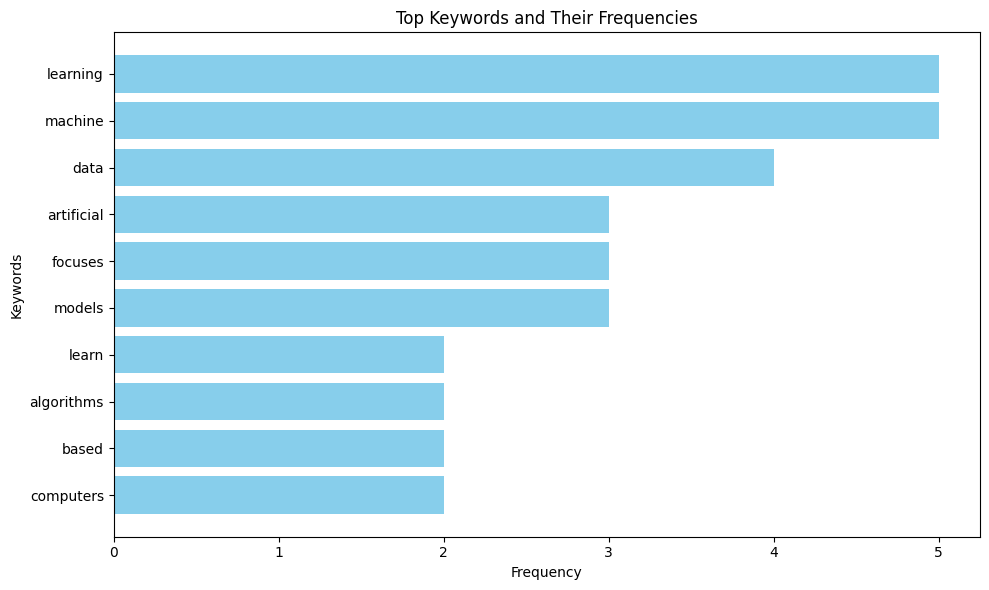

In [31]:
import matplotlib.pyplot as plt
# Rank keywords by frequency
sorted_keywords = sorted(keyword_freq.items(), key=lambda x: -x[1])

# Extract top keywords and frequencies
top_keywords = [keyword for keyword, freq in sorted_keywords[:10]]
top_frequencies = [freq for keyword, freq in sorted_keywords[:10]]

# Create a bar chart to visualize top keywords and frequencies
plt.figure(figsize=(10, 6))
plt.barh(top_keywords, top_frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.title('Top Keywords and Their Frequencies')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.tight_layout()

# Show the plot
plt.show()